<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q oec
import oec
import pandas as pd
import numpy as np
import os, os.path, csv, requests, pathlib
import math
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## OED data API functions

In [0]:
def build_call(*args):
    call_url = 'http://atlas.media.mit.edu/'
    for val in args:
        call_url += str(val) + '/'
    return call_url


def request_data(call_url):
    r = requests.get(call_url)
    response_dict = r.json()
    json_list = response_dict['data']  # list of dicts containing data
    return json_list


def get_countries(filename=None):
    call = build_call('attr', 'country')
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_products(classification, filename=None):
    call = build_call('attr', classification)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def get_trade(classification, trade_flow, year, origin, destination,product, filename=None):
    call = build_call(classification, trade_flow, year, origin, destination,
                      product)
    json_list = request_data(call)
    if filename is not None:
        data_to_csv(json_list, filename)
    return json_list


def trade_params(classification, trade_flow, year, origin, destination,product):
    parameters = {'classification': classification,
                  'trade_flow': trade_flow,
                  'year': year,
                  'origin': origin,
                  'destination': destination,
                  'product': product}
    return parameters


def get_header(json_list):
    header = set()
    for dict in json_list:
        header.update(dict.keys())
    header = list(header)
    header.sort()
    return header


def create_csv(json_list, filename):
    with open(filename, 'w') as csvfile:
        header = get_header(json_list)
        cw = csv.writer(csvfile)
        cw.writerow(header)
        for dict in json_list:
            row = dict_to_list(dict, header)
            cw.writerow(row)


def dict_to_list(dict, header):
    row = []
    for field in header:
        if field in dict:
            row.append(str(dict[field]))
        else:
            row.append(None)
    return row

In [11]:
oec.get_products

<function oec.get_products>

## Generate dataset

In [0]:
trade_codes = ['6519','6531','8471','6571','7849','7810','7842','7764','7723','7522','2924','5419','5417','7763','7711','7188']
PATH = '/content/drive/My Drive/Stellenbosch/Webster'
os.chdir(PATH)
trade_classification = 'sitc'
def countries_and_products():
  countries = oec.get_countries()
  products = oec.get_products(trade_classification)
  create_csv(countries,f'{PATH}/list_countries.csv')
  create_csv(products,f'{PATH}/list_products.csv')

In [0]:
countries_and_products()

In [162]:
products = pd.read_csv(f'{PATH}/list_products.csv',usecols=['id','name','display_id'])
products.rename(columns={'display_id':'sitc_id'},inplace=True)
products = products[products['sitc_id'].isin(trade_codes)]
products = products[['id','name']].astype('category')
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 48 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      16 non-null     category
 1   name    16 non-null     category
dtypes: category(2)
memory usage: 1.7 KB


In [0]:
import os.path
from os import path
def download_data(list_of_codes):
  for i in trade_codes:
    csv_name = f"{trade_classification}-{i}"
    # Set parameters to extract top exporters from the API documentation
    params = {'classification': trade_classification,
          'trade_flow': 'export',
          'year': 'all',
          'origin': 'show', #Set origin to all for comparison
          'destination': 'all',
          'product': i} #Set code for product of interest
    print(f'Data for {i} processed.....')
    oec_data = get_trade(**params)
    # Save the results in CSV file
    if path.exists(PATH):
      create_csv(oec_data,f'{csv_name}.csv')#,locals(),globals())
    else:
      print('Choose destination directory')

In [21]:
download_data(trade_codes)

Data for 6519 processed.....
Data for 6531 processed.....
Data for 8471 processed.....
Data for 6571 processed.....
Data for 7849 processed.....
Data for 7810 processed.....
Data for 7842 processed.....
Data for 7764 processed.....
Data for 7723 processed.....
Data for 7522 processed.....
Data for 2924 processed.....
Data for 5419 processed.....
Data for 5417 processed.....
Data for 7763 processed.....
Data for 7711 processed.....
Data for 7188 processed.....


In [0]:
import pandas as pd
import numpy as np
import os, os.path, csv, requests, pathlib
import math
from datetime import datetime

PATH = '/content/drive/My Drive/Stellenbosch/Webster'
include_list = ['year','origin_id','sitc_id','export_val','export_rca']
def create_df(path):
  trade_data = [i for i in os.listdir(path) if i.endswith('.csv') and 'sitc' in i]
  trade_history = []
  for file in trade_data:
    file_name = pd.read_csv(file,usecols=include_list,parse_dates=['year'])#, index_col=['year'])
    trade_history.append(file_name)
  products_dataframe = pd.concat(trade_history)
  return products_dataframe

In [133]:
trade_df = create_df(PATH)
country_list = pd.read_csv('list_countries.csv',usecols=['id','name'],
                        na_values='',na_filter=True)
country_list.rename(columns=lambda x: x.replace('name','country'), inplace=True)
country_list.rename(columns=lambda x: x.replace('id','origin_id'), inplace=True)
country_list.head(2)

,origin_id,country
0,af,Africa
1,afago,Angola


In [171]:
trade_dframe = trade_df.merge(country_list, on=['origin_id'],how='inner')
trade_dframe['sitc_id'].astype('category')
trade_dframe.drop(['origin_id'],axis=1,inplace=True)
trade_dframe.head(2)

,export_rca,export_val,sitc_id,year,country
0,0.020916,3000.0,606519,1962.0,Cote d'Ivoire
1,0.084925,15000.0,606519,1963.0,Cote d'Ivoire


In [0]:
trade_dframe = trade_dframe.drop(['origin_id'],axis=1)
# trade_dframe = trade_dframe[trade_dframe['export_val']]
trade_dframe.isnull().sum()

In [0]:
agg_product = pd.pivot_table(trade_dframe, index='year', columns='sitc_id', values='export_val', aggfunc=np.mean)
agg_product.fillna(0,inplace=True)
agg_country = pd.pivot_table(trade_dframe, index='year', columns='country', values='export_val', aggfunc=np.mean)
agg_south_africa = pd.pivot_table(trade_dframe[trade_dframe.country=="South Africa"], index='year', columns='sitc_id', values='export_val', aggfunc=np.mean)
agg_south_africa.fillna(0,inplace=True)

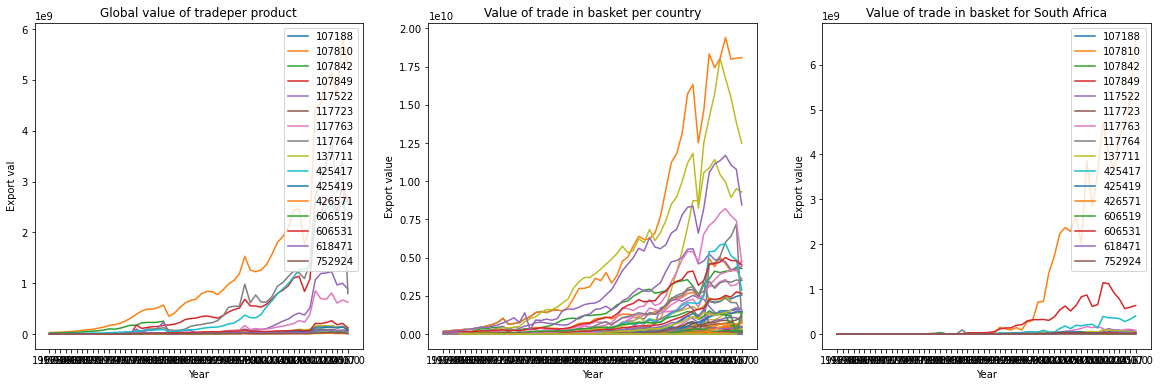

In [177]:
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.plot(agg_product) #/ agg_year_item.mean(0)[np.newaxis])
plt.title("Global value of tradeper product")
plt.xlabel("Year")
plt.legend(agg_product.columns,loc="upper right")
plt.ylabel("Export val")

plt.subplot(132)
plt.plot(agg_country) #/ agg_year_store.mean(0)[np.newaxis])
plt.title("Value of trade in basket per country")
plt.xlabel("Year")
plt.ylabel("Export value")

plt.subplot(133)
plt.plot(agg_south_africa) #/ agg_year_store.mean(0)[np.newaxis])
plt.title("Value of trade in basket for South Africa")
plt.xlabel("Year")
plt.legend(agg_south_africa.columns,loc="upper right")
plt.ylabel("Export value")
plt.show()

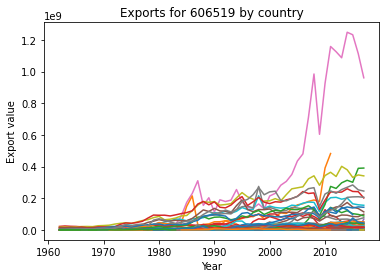

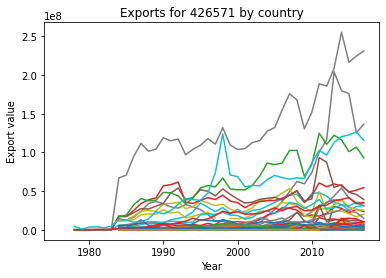

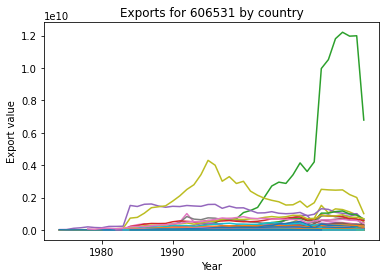

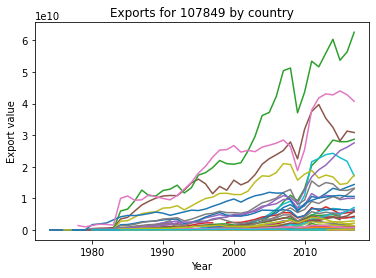

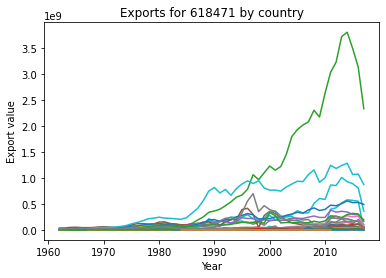

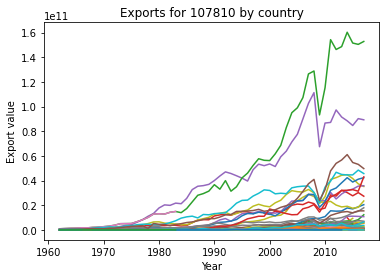

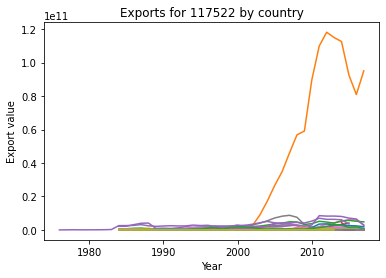

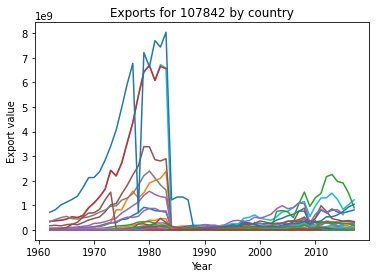

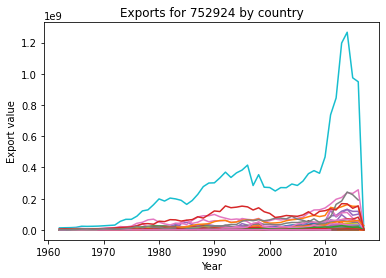

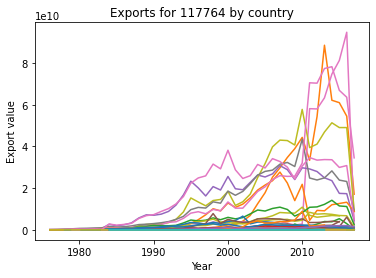

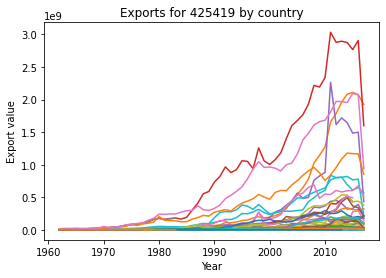

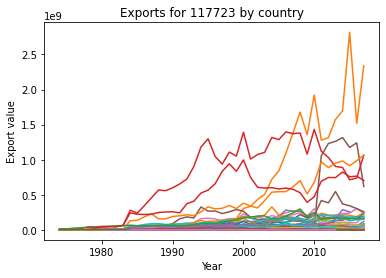

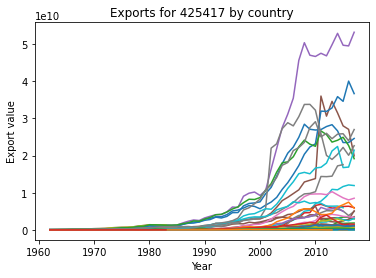

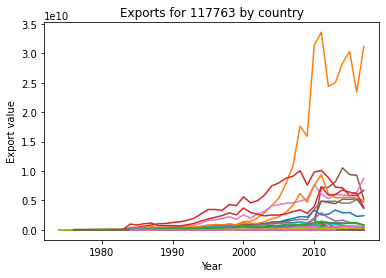

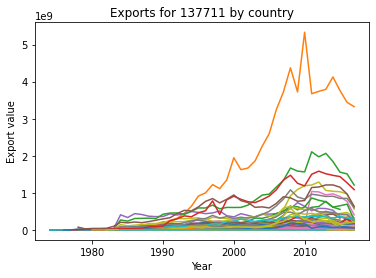

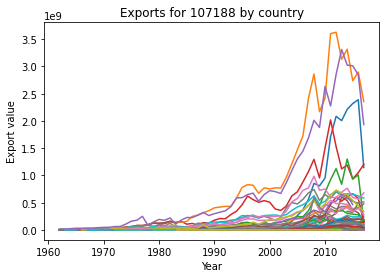

In [89]:
for id in trade_df.sitc_id.unique():
  agg_country_product = pd.pivot_table(trade_df[trade_df.sitc_id==id], index='year', columns='origin_id', values='export_val', aggfunc=np.mean)
  plt.plot(agg_country_product)
  plt.title(f"Exports for {id} by country")
  plt.xlabel("Year")
  plt.ylabel("Export value")
  plt.show()

In [0]:
## Requires df.melt() for 2D plot
ncols = 5
nrows = int(np.ceil(len(trade_dframe) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (southern_africa, trade_dframe) in enumerate(results.items()):
    if (len(result) >= 2):
      plot_rt(result, axes.flat[i], southern_africa)
    else:
      FILTERED_COUNTRIES.append(southern_africa)

fig.tight_layout()
fig.set_facecolor('w')

# Extract comprehensive features

### Packages

In [0]:
!pip install -q tsfresh 
import os
import logging
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

from tsfresh import extract_features, select_features
from tsfresh import defaults
from tsfresh.feature_extraction import feature_calculators
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters
from tsfresh.utilities import dataframe_functions, profiling
from tsfresh.utilities.distribution import MapDistributor, MultiprocessingDistributor,DistributorBaseClass
from tsfresh.utilities.string_manipulation import convert_to_output_format

import tsfresh
from tsfresh.feature_extraction.settings import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series

### Extract features

In [0]:
trade_dframe.head()

,export_rca,export_val,import_rca,import_val,sitc_id,year,country
0,0.020916,3000.0,0.0,24000.0,606519,1962-01-01,Cote d'Ivoire
1,0.025602,6000.0,0.0,21000.0,606519,1962-01-01,Democratic Republic of the Congo
2,0.001952,1000.0,0.0,207000.0,606519,1962-01-01,Algeria
3,0.078182,11000.0,0.0,36000.0,606519,1962-01-01,Egypt
4,0.141766,17000.0,0.0,129000.0,606519,1962-01-01,Kenya


In [0]:
extracted_features = extract_features(
    trade_dframe[['export_rca',"export_val","import_rca","import_val","year","country"]], 
    column_id="country", 
    column_sort="year",
    column_value=None,column_kind=None,
    chunksize=None,
    default_fc_parameters=ComprehensiveFCParameters(),
    # default_fc_parameters=EfficientFCParameters(),
    )
extracted_features.to_csv("tfresh_comprehensive_nositcnames.csv")
feature_names = extracted_features.columns


Feature Extraction: 100%|██████████| 5/5 [04:32<00:00, 54.54s/it]


In [0]:
extracted_features = extract_features(
    trade_dframe[['export_rca',"export_val","import_rca","import_val","year","country"]], 
    column_id="country", 
    column_sort="year",
    column_value=None,column_kind=None,
    chunksize=None,
    default_fc_parameters=EfficientFCParameters(),
    )
# extracted_features.to_csv("tfresh_efficientfc_nositcnames.csv") #merge with trade data
# feature_names_efc = extracted_features.columns


Feature Extraction:  60%|██████    | 3/5 [01:11<00:47, 24.00s/it]